### I. Chuẩn bị dữ liệu
#### 1.Đọc file và lọc mã VCI: Chỉ dùng giá đóng cửa cho ARIMA

In [ ]:
import statsmodels
import pmdarima
import pandas as pd

df =pd.read_csv("clean_stock_data.csv")
df.head(5)

,time,symbol,open,high,low,close,volume
0,2020-01-02,A32,17.05,17.05,17.05,17.05,300.0
1,2020-01-03,A32,14.92,14.92,14.92,14.92,500.0
2,2020-01-04,A32,14.92,14.92,14.92,14.92,0.0
3,2020-01-05,A32,14.92,14.92,14.92,14.92,0.0
4,2020-01-06,A32,14.92,14.92,14.92,14.92,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318519 entries, 0 to 3318518
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   symbol  object 
 2   open    float64
 3   high    float64
 4   low     float64
 5   close   float64
 6   volume  float64
dtypes: float64(5), object(2)
memory usage: 177.2+ MB


**Set định dạng datetime cho cột time**

In [4]:
df['time'] = pd.to_datetime(df['time'], errors="coerce")

#### 2. Đánh giá và lựa chọn mã cổ phiếu phù hợp cho mô hình
##### 2.1. Lấy danh sách mã cổ phiếu

In [2]:
symbols = df['symbol'].unique()
len(symbols), symbols[:10]

(1690,
 array(['A32', 'AAA', 'AAH', 'AAM', 'AAS', 'AAT', 'AAV', 'ABB', 'ABC',
        'ABI'], dtype=object))

##### 2.2. Đánh giá chất lượng cho từng mã
**Tiêu chí chọn mã phù hợp chạy ARIMA / LSTM**
1. Đủ độ dài dữ liệu
- ARIMA: tối thiểu 300 quan sát (≈ 1–1.5 năm)
- LSTM: tối thiểu 600–1000 quan sát (≈ 3–4 năm)

2. Không bị thiếu ngày giao dịch kéo dài
- Không có đoạn missing dài hơn 5–10 ngày liên tục

3. Thanh khoản đủ cao
- Volume > 0 trong đa phần các ngày
- Tránh penny stock thanh khoản thấp → dễ gây flat price

4. Giá không đi ngang nhiều
- Không có đoạn giá close giống nhau > 15–20 ngày liên tiếp → sai lệch mô hình

5. Không có lỗi dữ liệu
- Không có giá âm
- Không có close < open trong nhiều ngày bất thường
- Không có high < low

In [3]:
import numpy as np

def evaluate_symbol(symbol):
    sub = df[df['symbol'] == symbol].sort_values('time')

    # 1) Chiều dài dữ liệu
    n = len(sub)
    
    # 2) Số ngày close không đổi
    flat_days = (sub['close'].diff() == 0).sum()

    # 3) Volume bằng 0
    vol_zero = (sub['volume'] == 0).sum()

    # 4) Missing days liên tục
    sub = sub.set_index('time')
    missing = sub.asfreq('1D')['close'].isna()
    max_missing_streak = missing.astype(int).groupby((missing != missing.shift()).cumsum()).sum().max()

    # 5) Lỗi dữ liệu
    invalid_price = ((sub['low'] > sub['high']) | (sub['close'] < 0)).sum()

    score = 0

    # scoring logic
    if n > 800: score += 2
    elif n > 400: score += 1

    if flat_days < 10: score += 2
    elif flat_days < 30: score += 1

    if vol_zero < 5: score += 2
    elif vol_zero < 30: score += 1

    if max_missing_streak < 5: score += 2
    elif max_missing_streak < 15: score += 1

    if invalid_price == 0: score += 1

    return {
        'symbol': symbol,
        'length': n,
        'flat_days': flat_days,
        'vol_zero': vol_zero,
        'max_missing_streak': max_missing_streak,
        'invalid_price': invalid_price,
        'score': score
    }


In [4]:
results = [evaluate_symbol(s) for s in symbols]
results_df = pd.DataFrame(results)

results_df = results_df.sort_values("score", ascending=False)
results_df.head(20)

,symbol,length,flat_days,vol_zero,max_missing_streak,invalid_price,score
628,HPO,1,0,0,1,0,7
438,EAD,1,0,0,1,0,7
1350,TDI,1,0,0,1,0,7
139,BQP,14,4,4,14,0,6
931,NS3,8,2,2,8,0,6
1137,RGG,20,8,6,20,0,4
1343,TCX,29,9,8,29,0,4
13,ABW,904,449,284,904,0,3
14,ACB,2148,837,685,2148,0,3
15,ACC,2148,1050,694,2148,0,3


**Chọn mã cổ phiếu ACB**
(Do đảm bảo độ lớn của mẫu)

In [5]:
symbol = "ACB" 
dft = df[df['symbol'] == symbol].copy()
dft = dft.sort_values("time")

ts = dft.set_index('time')['close'] 
ts = ts.asfreq('D')  # Chuyển đổi tần suất dữ liệu theo ngày

ts.head()

time
2020-01-02    6.64
2020-01-03    6.64
2020-01-04    6.64
2020-01-05    6.64
2020-01-06    6.49
Freq: D, Name: close, dtype: float64

### II. Mô hình
#### 1. Kiểm tra tính dừng của chuỗi (Stationarity)

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -0.8730127805178948
p-value: 0.7967297535748783


*-> p-value >= 0.05 => Chuỗi không dừng => Lấy sai phân*

**Lấy sai phân bậc 1**

In [7]:
ts_diff = ts.diff().dropna()
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -24.230885928358393
p-value: 0.0


**=> Chuỗi dừng khi sai phân bậc 1**

#### 2. Chạy mô hình

##### 2.1. Chạy auto ARIMA
Bước này sử dụng thư viện pmdarima để tự động tìm kiếm các tham số tối ưu (p, d, q) cho mô hình ARIMA dựa trên dữ liệu chuỗi thời gian ts (giá đóng cửa cổ phiếu đã được xử lý).
- seasonal=False: Không xem xét yếu tố mùa vụ (vì dữ liệu chứng khoán thường không có mùa vụ rõ ràng).
- stepwise=True: Sử dụng phương pháp stepwise để tìm kiếm hiệu quả.
- trace=True: Hiển thị quá trình tìm kiếm các mô hình.
- error_action='ignore': Bỏ qua lỗi nếu có.
- suppress_warnings=True: Ẩn cảnh báo.

Sau đó, in tóm tắt mô hình (summary) để xem các tham số được chọn và các chỉ số đánh giá như AIC, BIC.

In [ ]:
from pmdarima import auto_arima

model_auto = auto_arima(
    ts,
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-336.293, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-328.454, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-329.089, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-329.005, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-327.257, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-325.005, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-325.715, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-328.627, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-334.300, Time=3.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-327.257, Time=0.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-329.606, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-330.104, Time=0.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-332.304, Time=2.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-335.074, Time=0.87 sec

Best model:  ARIMA(2,1,2)(0,0,0)

##### 2.2. Kiểm tra tính phù hợp của mô hình
Sau khi có tham số từ auto ARIMA, bước này sử dụng statsmodels để fit mô hình ARIMA chính thức với các tham số (p, d, q) đã chọn.

In [9]:
import statsmodels.api as sm

p, d, q = model_auto.order
model = sm.tsa.ARIMA(ts, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2148
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 172.537
Date:                Tue, 18 Nov 2025   AIC                           -335.074
Time:                        15:38:11   BIC                           -306.715
Sample:                    01-02-2020   HQIC                          -324.698
                         - 11-18-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3740      0.062     -6.074      0.000      -0.495      -0.253
ar.L2         -0.8277      0.065    -12.748      0.000      -0.955      -0.700
ma.L1          0.3426      0.058      5.905      0.0

**=> P-value < 0.05 => Mô hình được coi là phù hợp**

##### 2.3. Biểu diễn phần dư (residual)
Residuals (phần dư) là sự khác biệt giữa giá trị thực tế và giá trị dự đoán của mô hình. Bước này tạo series residuals từ mô hình auto ARIMA, sau đó vẽ:

Plot residuals theo thời gian: Để xem có xu hướng hoặc biến động bất thường không.
Histogram với KDE: Để kiểm tra phân phối (nên gần chuẩn, trung bình ≈ 0).

ACF và PACF: Để kiểm tra autocorrelation (nếu không có, residuals là white noise, mô hình tốt).

In [ ]:
residuals = pd.Series(model_auto.resid(), index=ts.index)

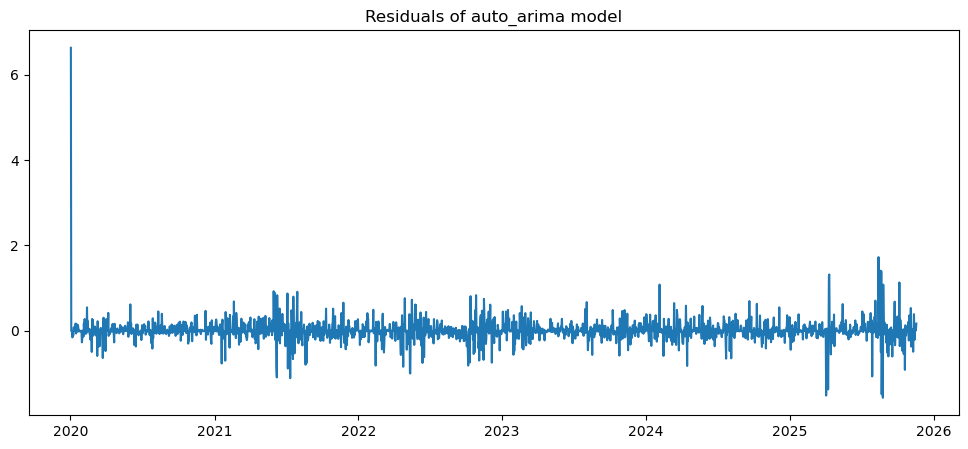

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title('Residuals of auto_arima model')
plt.show()

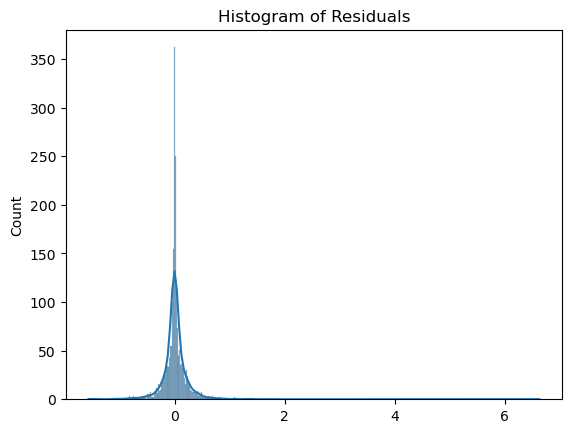

In [16]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

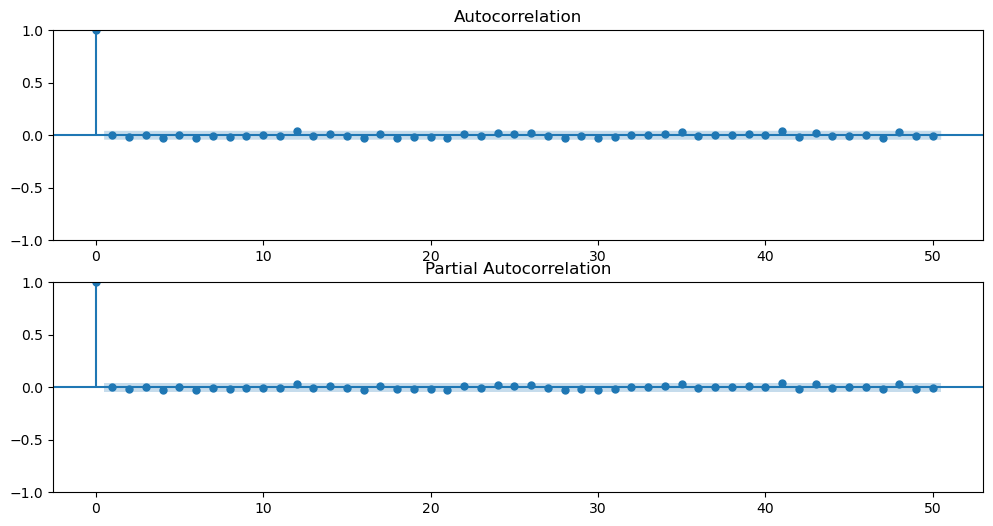

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2,1, figsize=(12,6))
plot_acf(residuals, ax=axes[0], lags=50)
plot_pacf(residuals, ax=axes[1], lags=50)
plt.show()

**=> Residuals phân phối chuẩn, không có autocorrelation (ACF/PACF gần 0), và không có xu hướng rõ ràng**

##### 2.4. Kiểm tra Ljung-Box test
Sử dụng Ljung-Box test để kiểm tra xem residuals có autocorrelation không (H0: không có autocorrelation).

lags=[10]: Kiểm tra đến lag 10.
Nếu p-value > 0.05, không từ chối giả thuyết (residuals là nhiễu trắng).

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box)

     lb_stat  lb_pvalue
10  4.812773   0.903329


*=> p-value > 0.05, residuals không có autocorrelation, nghĩa là mô hình đã giải thích hết thông tin trong dữ liệu.*

##### 2.6. Forecast (Dự báo)
Dự báo 30 bước (ngày) tiếp theo bằng phương pháp static (dựa trên dữ liệu lịch sử, không cập nhật).

In [10]:
forecast = model_fit.forecast(steps=30)
forecast

2025-11-19    25.160840
2025-11-20    25.160500
2025-11-21    25.193041
2025-11-22    25.181153
2025-11-23    25.158664
2025-11-24    25.176915
2025-11-25    25.188704
2025-11-26    25.169188
2025-11-27    25.166728
2025-11-28    25.183803
2025-11-29    25.179453
2025-11-30    25.166947
2025-12-01    25.175224
2025-12-02    25.182480
2025-12-03    25.172915
2025-12-04    25.170486
2025-12-05    25.179312
2025-12-06    25.178022
2025-12-07    25.171199
2025-12-08    25.174819
2025-12-09    25.179113
2025-12-10    25.174510
2025-12-11    25.172677
2025-12-12    25.177172
2025-12-13    25.177008
2025-12-14    25.173349
2025-12-15    25.174853
2025-12-16    25.177320
2025-12-17    25.175152
2025-12-18    25.173921
Freq: D, Name: predicted_mean, dtype: float64

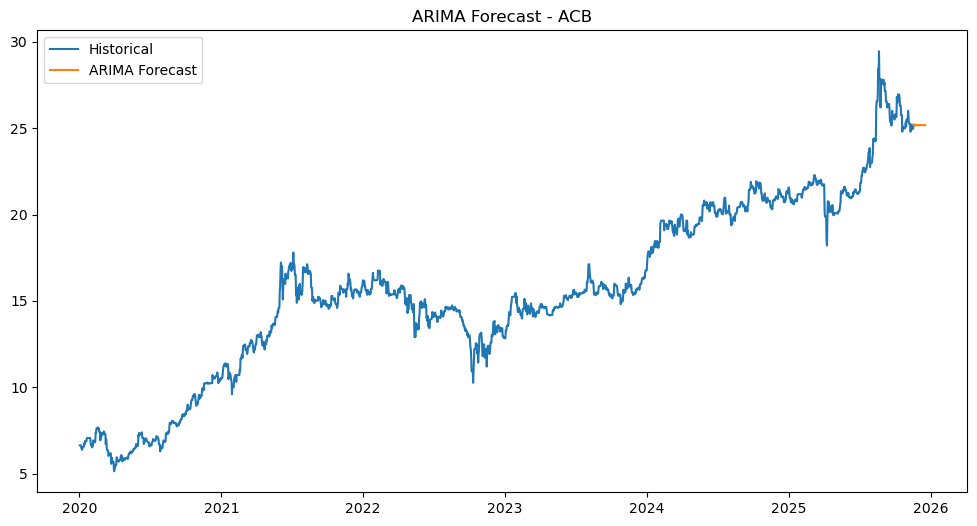

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ts, label='Historical')
plt.plot(forecast, label='ARIMA Forecast')
plt.title(f"ARIMA Forecast - {symbol}")
plt.legend()
plt.show()

**Static forecast, Dynamic forecast, Forecast với confidence intervals**
- Static forecast: Dự báo từng bước dựa trên dữ liệu lịch sử cố định (không sử dụng dự báo trước).
- Dynamic forecast: Dự báo dựa trên dự báo trước đó (tích lũy lỗi).
- Forecast với CI: Bao gồm khoảng tin cậy (lower/upper bounds) để đánh giá độ không chắc chắn.

Dự báo 300 ngày để có tầm nhìn dài hạn.

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2148
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 172.537
Date:                Tue, 18 Nov 2025   AIC                           -335.074
Time:                        16:39:47   BIC                           -306.715
Sample:                    01-02-2020   HQIC                          -324.698
                         - 11-18-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3740      0.062     -6.074      0.000      -0.495      -0.253
ar.L2         -0.8277      0.065    -12.748      0.000      -0.955      -0.700
ma.L1          0.3426      0.058      5.905      0.0

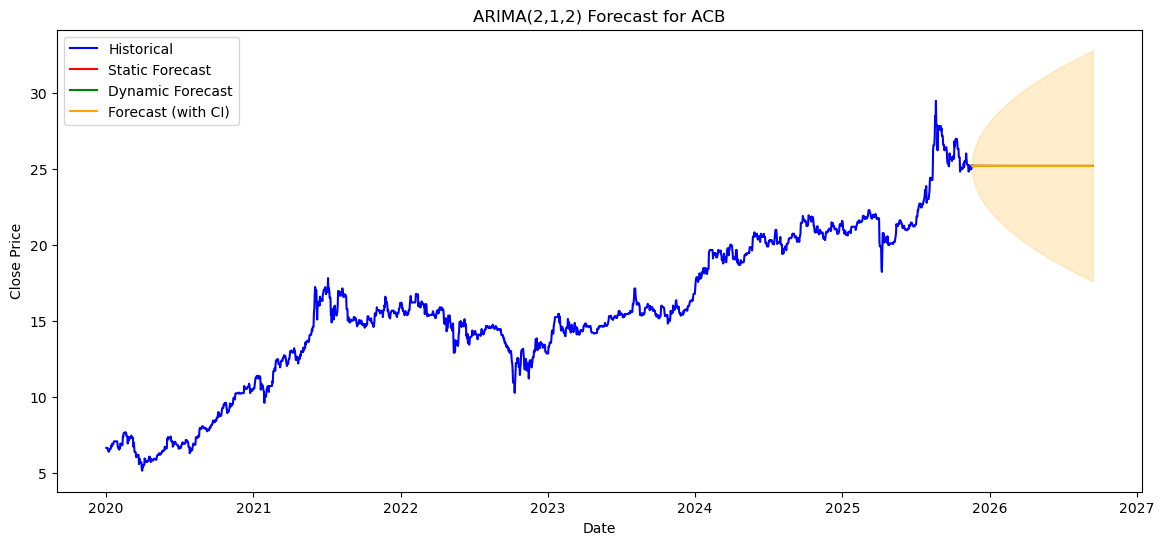

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA(2,1,2)
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

# Static forecast 
n_forecast = 300  # số ngày dự báo
forecast_static = model_fit.predict(start=len(ts), end=len(ts)+n_forecast-1, dynamic=False)

# Dynamic forecast (dựa trên dự báo trước)
forecast_dynamic = model_fit.predict(start=len(ts), end=len(ts)+n_forecast-1, dynamic=True)

# Forecast với confidence intervals
forecast_ci = model_fit.get_forecast(steps=n_forecast)
forecast_mean = forecast_ci.predicted_mean
forecast_lower = forecast_ci.conf_int()['lower close']
forecast_upper = forecast_ci.conf_int()['upper close']

# Vẽ kết quả
plt.figure(figsize=(14,6))
plt.plot(ts, label='Historical', color='blue')
plt.plot(forecast_static.index, forecast_static.values, label='Static Forecast', color='red')
plt.plot(forecast_dynamic.index, forecast_dynamic.values, label='Dynamic Forecast', color='green')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast (with CI)', color='orange')
plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper, color='orange', alpha=0.2)
plt.title(f'ARIMA(2,1,2) Forecast for {symbol}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Static forecast thường chính xác hơn cho ngắn hạn, trong khi dynamic có thể tích lũy lỗi cho dài hạn. CI giúp đánh giá rủi ro (ví dụ, 95% khả năng giá nằm trong khoảng). Nếu CI rộng, mô hình kém chắc chắn; nếu hẹp, dự báo đáng tin cậy hơn.

**Kết luận**

Mô hình ARIMA đã được xây dựng và đánh giá kỹ lưỡng, từ tự động chọn tham số đến kiểm tra residuals và dự báo. Nếu tất cả các kiểm tra (p-value, Ljung-Box, residuals) đều tốt, mô hình phù hợp cho dự đoán giá cổ phiếu ngắn đến trung hạn. Tuy nhiên, ARIMA có hạn chế với dữ liệu phi tuyến, nên có thể so sánh với LSTM trong phần tiếp theo. Để cải thiện, có thể thử nghiệm thêm tham số hoặc sử dụng dữ liệu bổ sung như volume.